# Imports

# GPU Info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  8 23:06:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir /content/dataset

In [ ]:
!unzip '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/1

# Hyperparameters Setup

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
EPOCHS = 100
NUM_CLASSES = 2
CLASSES = ["Normal", "Stroke"]

In [ ]:
import keras 
import tensorflow as tf

LOSS = tf.keras.losses.BinaryCrossentropy() # Not un-weighted 
METRICS = [
      keras.metrics.CategoricalAccuracy(name="accuracy"),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

# Dataset Setup

In [ ]:
import os

DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

path, dirs, files = next(os.walk(DF_TRAIN + "/Stroke"))
file_count = len(files)
print('Stroke:', file_count)
path, dirs, files = next(os.walk(DF_TRAIN + "/Normal"))
file_count = len(files)
print('Non-Stroke:', file_count)

Stroke: 825
Non-Stroke: 1426


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(validation_split = 0.2, rotation_range = 0.2)
test_gen  = ImageDataGenerator()

# load training and validating images from directory
train_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'training',
                                          seed = 956,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE)
                                          )

valid_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'validation',
                                          seed = 343,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE)
                                          )

test_set  = test_gen.flow_from_directory(DF_TEST,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE)
                                         )

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 1801 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


# Show Image Samples

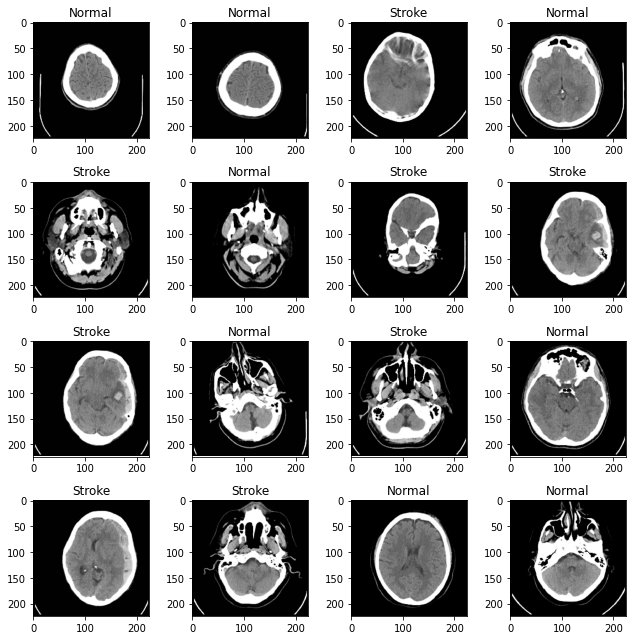

In [ ]:
# show images from dataset
import matplotlib.pyplot as plt

images, labels = next(test_set)
labels = labels.argmax(axis=1)
fig, axes = plt.subplots(4, 4, figsize = (9, 9))

axes = axes.flatten()
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.astype("uint8"))
    ax.set_title(CLASSES[label.astype(int)])
plt.tight_layout()
plt.show()

# Experiments

## Auxiliar Functions

In [ ]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss', mode='min', save_best_only=True)
    callbacks.append(checkpoint)
    anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001, min_delta=0.00001, mode='auto') 
    callbacks.append(anne)
    return callbacks

In [ ]:
def plot_training_results(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

## EfficientNetB4

### Build Model

In [ ]:
# create EfficientNetB4 base model
base_model = tf.keras.applications.EfficientNetB4(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')                                                                   
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=.2, seed = 123)(x)        
predictions = tf.keras.layers.Dense(NUM_CLASSES, activation = 'sigmoid', name = 'Final')(x)
model_effnet = tf.keras.models.Model(name = "efficientnetb4", inputs = base_model.input, outputs = predictions)

model_effnet.compile(
    optimizer = OPTIMIZER,
    loss = LOSS,
    metrics = METRICS,
)

In [ ]:
model_effnet.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization_4 (Normalization  (None, 224, 224, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                     

### Train Model

In [ ]:
# train the model
from datetime import datetime

start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('efficientnetb4')
history_eff = model_effnet.fit(train_set,
                               epochs = EPOCHS,
                               validation_data = valid_set,
                               callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-09 12:09:45.532278


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 0.5067 - accuracy: 0.7413 - tp: 1340.0000 - fp: 459.0000 - tn: 1342.0000 - fn: 461.0000 - BinaryAccuracy: 0.7446 - precision: 0.7449 - recall: 0.7440 - auc: 0.8277
Epoch 00001: val_loss improved from inf to 1.84708, saving model to model.efficientnetb4.h5
113/113 [==============================] - 67s 397ms/step - loss: 0.5067 - accuracy: 0.7413 - tp: 1340.0000 - fp: 459.0000 - tn: 1342.0000 - fn: 461.0000 - BinaryAccuracy: 0.7446 - precision: 0.7449 - recall: 0.7440 - auc: 0.8277 - val_loss: 1.8471 - val_accuracy: 0.6533 - val_tp: 294.0000 - val_fp: 156.0000 - val_tn: 294.0000 - val_fn: 156.0000 - val_BinaryAccuracy: 0.6533 - val_precision: 0.6533 - val_recall: 0.6533 - val_auc: 0.6976 - lr: 0.0010
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.8790 - tp: 1580.0000 - fp: 216.0000 - tn: 1585.0000 - fn: 221.0000 - BinaryAccuracy: 0.8787 - precision: 0.8797 - recall: 0.8773

In [ ]:
!cp '/content/model.efficientnetb4.h5' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/weights/model.efficientnetb4.h5'

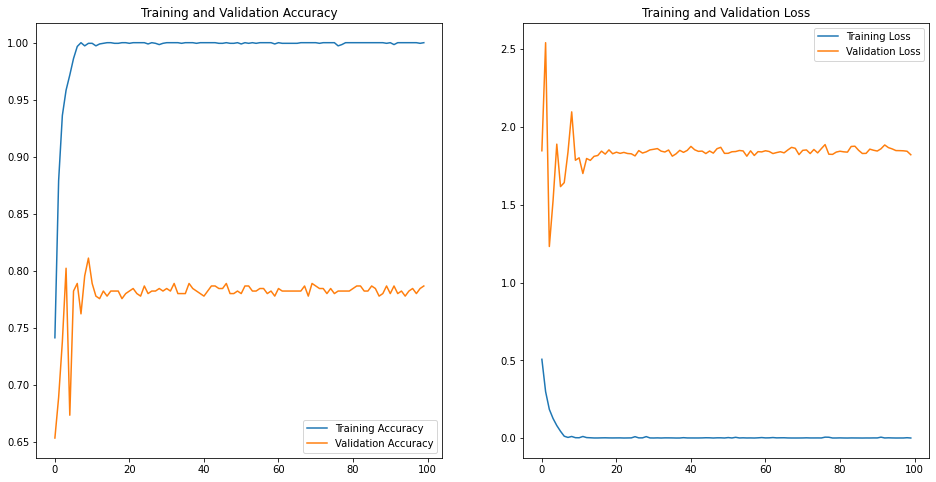

In [ ]:
plot_training_results(history_eff)

### Evaluate Model

In [ ]:
# get results
test_set.reset()
results = model_effnet.evaluate(test_set, steps = len(test_set), verbose = 1, return_dict = True)

16/16 [==============================] - 1s 61ms/step - loss: 1.1833 - accuracy: 0.7920 - tp: 199.0000 - fp: 52.0000 - tn: 198.0000 - fn: 51.0000 - BinaryAccuracy: 0.7940 - precision: 0.7928 - recall: 0.7960 - auc: 0.8466


In [ ]:
# show results
print('EfficientNetB4:')
print('---------------')
print("Accuracy:",(results['accuracy']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

EfficientNetB4:
---------------
Accuracy: 0.7919999957084656
Binary Accuracy: 0.7940000295639038
Precision: 0.7928286790847778
Recall: 0.7960000038146973
AUC: 0.8465840220451355
F1 Score: 0.7944111764450235


### Predict Images

[1 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1]
[1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1]

Classification Report
              precision    recall  f1-score   support

      Normal       1.00      0.86      0.92         7
      Stroke       0.90      1.00      0.95         9

   micro avg       0.94      0.94      0.94        16
   macro avg       0.95      0.93      0.94        16
weighted avg       0.94      0.94      0.94        16
 samples avg       0.94      0.94      0.94        16

Confusion Matrix
[[6 1]
 [0 9]]


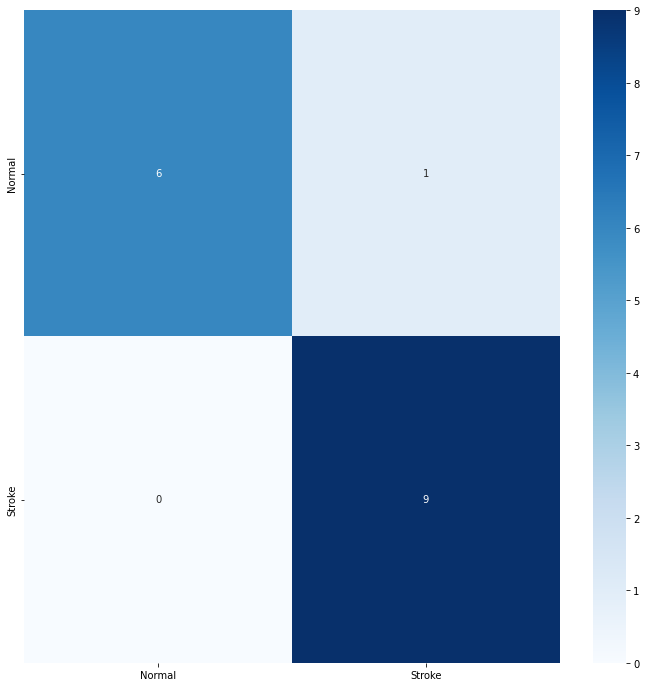

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

images, labels = next(test_set)

Y_pred = model_effnet.predict(images)
y_pred = (Y_pred > 0.8).astype("int32")

print(y_pred.argmax(axis=1))
print(labels.argmax(axis=1))

print('\nClassification Report')
print(classification_report(labels, y_pred, target_names = CLASSES))

confusionmatrix = confusion_matrix(labels.argmax(axis=1), y_pred.argmax(axis=1))
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = CLASSES, yticklabels = CLASSES)

## ViT B32

### Build Model

In [ ]:
!pip install -U vit-keras
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
# build vit model with 32 patch_size
from vit_keras import vit

base_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = NUM_CLASSES)
base_model.trainable = True

x = base_model.output
predictions = tf.keras.layers.Dense(NUM_CLASSES, activation = 'sigmoid', name = 'Final')(x)
model_vit = tf.keras.models.Model(name = "vit_b16", inputs = base_model.input, outputs = predictions)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model_vit.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = METRICS)

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


In [ ]:
model_vit.summary()

Model: "vit_b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape_3 (Reshape)         (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

### Train Model

In [ ]:
# train the model
from datetime import datetime

start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vitb32')
history_vit = model_vit.fit(train_set,
                            epochs = EPOCHS,
                            validation_data = valid_set,
                            callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-09 13:23:24.449655
Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 0.7202 - accuracy: 0.6426 - tp: 1285.0000 - fp: 708.0000 - tn: 1343.0000 - fn: 766.0000 - BinaryAccuracy: 0.6407 - precision: 0.6448 - recall: 0.6265 - auc: 0.6727
Epoch 00001: val_loss improved from inf to 0.64981, saving model to model.vitb32.h5
113/113 [==============================] - 58s 336ms/step - loss: 0.7202 - accuracy: 0.6426 - tp: 1285.0000 - fp: 708.0000 - tn: 1343.0000 - fn: 766.0000 - BinaryAccuracy: 0.6407 - precision: 0.6448 - recall: 0.6265 - auc: 0.6727 - val_loss: 0.6498 - val_accuracy: 0.6756 - val_tp: 309.0000 - val_fp: 153.0000 - val_tn: 297.0000 - val_fn: 141.0000 - val_BinaryAccuracy: 0.6733 - val_precision: 0.6688 - val_recall: 0.6867 - val_auc: 0.6981 - lr: 0.0010
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.7907 - tp: 1426.0000 - fp: 379.0000 - tn: 1422.0000 - fn: 375.0000 - BinaryAccuracy: 0.7907 - precision: 0.79

In [ ]:
!cp '/content/model.vitb32.h5' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/weights/model.vitb32.h5'

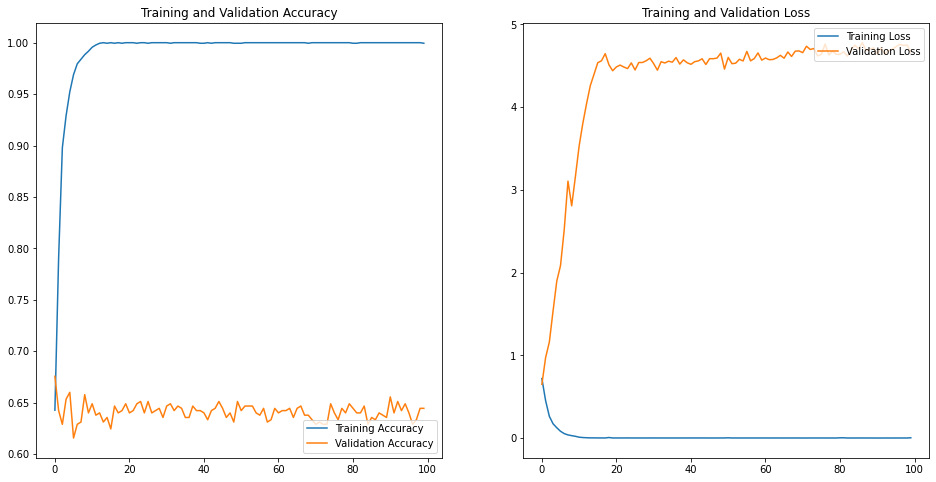

In [ ]:
plot_training_results(history_vit)

### Evaluate Model

In [ ]:
# get results
test_set.reset()
results = model_vit.evaluate(test_set, steps = len(test_set), verbose = 1, return_dict = True)

16/16 [==============================] - 1s 78ms/step - loss: 3.9849 - accuracy: 0.7240 - tp: 181.0000 - fp: 68.0000 - tn: 182.0000 - fn: 69.0000 - BinaryAccuracy: 0.7260 - precision: 0.7269 - recall: 0.7240 - auc: 0.7424


In [ ]:
# show results
print('ViT B32:')
print('---------------')
print("Accuracy:",(results['accuracy']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ViT B32:
---------------
Accuracy: 0.7239999771118164
Binary Accuracy: 0.7260000109672546
Precision: 0.7269076108932495
Recall: 0.7239999771118164
AUC: 0.7424400448799133
F1 Score: 0.7254508805384788


### Predict Images

[0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1]
[0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1]

Classification Report
              precision    recall  f1-score   support

      Normal       0.80      0.80      0.80        10
      Stroke       0.67      0.67      0.67         6

   micro avg       0.75      0.75      0.75        16
   macro avg       0.73      0.73      0.73        16
weighted avg       0.75      0.75      0.75        16
 samples avg       0.75      0.75      0.75        16

Confusion Matrix
[[8 2]
 [2 4]]


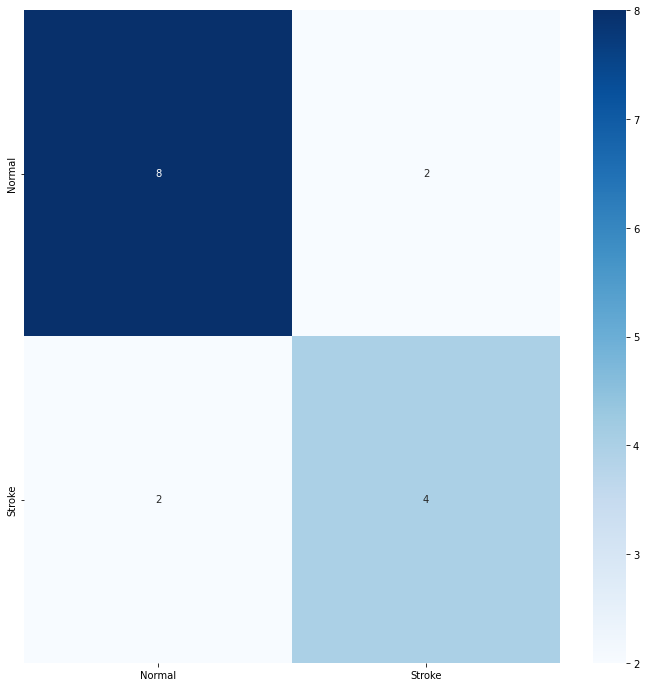

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

images, labels = next(test_set)

Y_pred = model_vit.predict(images)
y_pred = (Y_pred > 0.8).astype("int32")

print(y_pred.argmax(axis=1))
print(labels.argmax(axis=1))

print('\nClassification Report')
print(classification_report(labels, y_pred, target_names = CLASSES))

confusionmatrix = confusion_matrix(labels.argmax(axis=1), y_pred.argmax(axis=1))
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = CLASSES, yticklabels = CLASSES)

# Predict Tests

In [ ]:
test_set.reset()
Y_pred_1 = model_vit.predict(test_set)
# y_pred_1 = (Y_pred_1 > 0.9).astype("int32")
y_pred_1 = Y_pred_1.argmax(axis=1)

In [ ]:
print(test_set.index_array)

[165 228 176   4  27 194  55 128 161  11  90 241  81  56   9 214 162 106
 129  18  63 155   6   5 141  76  24   7  23  37 240  78  62 107 142 187
 215  66 102  67 191  68 157  47 179  86  83 177 236  70  35  12 233 112
 104  74 220 131  39  22 116 109 113 218 127  73 242 243  58   3 143 156
  45 132 211 198 121 170  31  91  88 210  29  16 153 123  19  33  72  87
 217 115 229 184  80 164 216  64 181 126  57 125 234 103  75 175 213 144
 201 122 163  54 192  99   1 133 183 178  21 119 195 118 169 101  13  82
 135  51 202 203  89 150  32  38 182 167  49 221 232   0 117 224 206 171
 139 209 108 227   2  92 147 185 244 245  61 204  26 134  98  48 249 199
  94 186  30 239 140 158  44  71  43  59  93 152 226  95 148  50 136 196
 173 145  25 189 149  17 247  41  14  60 223 100 225 205 154 138 159 130
 193 231 120 207 222 151  53 172 235 200  84 146 124 168 230  15  34 137
  77  10  46 208 180 166  42 248 110  79 238 197  96 114 160 111  69 219
  28  52  40 237   8 212 246  85 190  97  20  65 10

In [ ]:
f_classes = []
idx_class = test_set.index_array
for idc in idx_class:
  f_classes.append(test_set.classes[idc])

In [ ]:
print(np.array(f_classes))

[1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1
 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1
 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1
 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1
 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1
 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1]


In [ ]:
print(Y_pred_1.argmax(axis=1))

[0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0
 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1
 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0
 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0
 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0]


In [ ]:
print(y_pred_1)

[0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0
 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1
 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0
 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0
 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0]



Classification Report
              precision    recall  f1-score   support

      Normal       0.51      0.64      0.57       125
      Stroke       0.52      0.38      0.44       125

    accuracy                           0.51       250
   macro avg       0.51      0.51      0.50       250
weighted avg       0.51      0.51      0.50       250

Confusion Matrix
[[80 45]
 [77 48]]


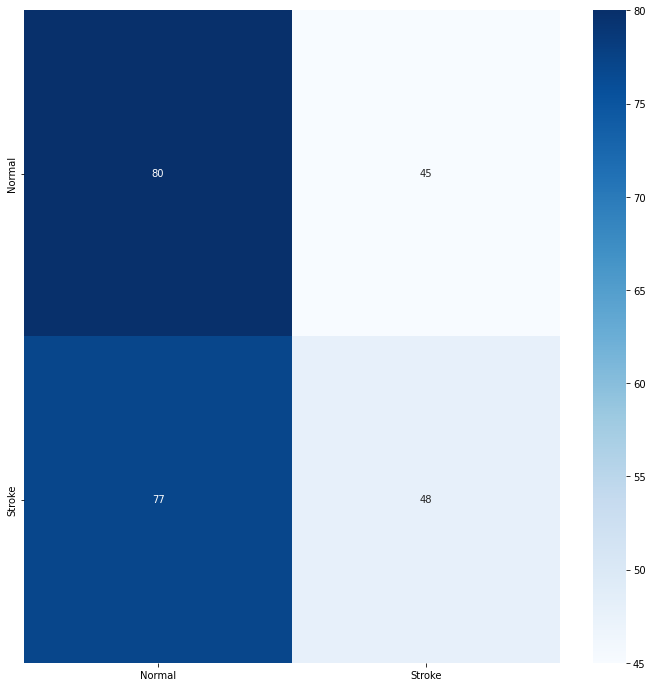

In [ ]:
print('\nClassification Report')
print(classification_report(f_classes, y_pred_1, target_names = CLASSES))

confusionmatrix = confusion_matrix(f_classes, y_pred_1)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = CLASSES, yticklabels = CLASSES)